<h1 'style=text-align:center';>REGIONAL FORCASTING OF GHANA COVID-19 CASES</h1>

# 1. Introduction

The goal of this notebook is very simple: Predict for the next $7$ days ahead, the number of covid-19 positive cases to be recorded in each of the sixteen (16) Geographical regions in Ghana.

We used the walk-forward dataset split approach to train and test our dataset.

The CNN network would take the following as features:

*     The days in the week (7 days which is equivalent to $7$ hot-encoded features)
*     The number of accumulated covid-19 positive cases
*     The number of recovered patients 
*     Percentage of recovered cases
*     Number of active covid-19 cases
*     The number of covid-19 new cases 

Outputs:
*    number of covid-19 positive cases for the next $7$ days


In [4]:
# !pip install --upgrade tensorflow

ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.


    tensorflow from https://files.pythonhosted.org/packages/61/e1/1e713485caee272e7be779ac10bb0cec36ace3d9f981e067a9105a736791/tensorflow-2.3.1-cp38-cp38-win_amd64.whl#sha256=87b62ab25816597a5e5352604b383b292eafd19a33ae7848b5275ea74fc4da1d:
        Expected sha256 87b62ab25816597a5e5352604b383b292eafd19a33ae7848b5275ea74fc4da1d
             Got        eeb63dfe8108560dba2ef50ded3e30479cf6352d92127a3b88f11bd955404038



In [1]:
# Import all the necesdsary libraries

import numpy as np
import pandas as pd

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL) # suppress unhelpful tf warnings

from keras.models import Model,load_model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping

import kerastuner as kt
from kerastuner import HyperModel,RandomSearch

In [2]:
# Read the main data file
df = pd.read_csv('data/Covid19_dataset_v2.csv').sort_values('date',ascending=True).astype(str)

# preview ten random sample of the data
df.sample(10)

,region,cases,recovered,recovered_perc,active_cases,date
52,Central,1918,1866,97.3,36,2020-09-14
885,Eastern,1214,1153,95.0,55,2020-07-23
470,Greater Accra,21567,20941,97.1,534,2020-08-19
184,Northern,528,516,97.7,1,2020-09-06
55,North East,19,18,94.7,0,2020-09-14
1100,Upper West,70,70,100.0,0,2020-07-10
1244,Upper West,55,54,98.2,1,2020-07-01
1228,Upper West,55,54,98.2,1,2020-07-02
180,Central,1904,1752,92.0,138,2020-09-06
752,Ahafo,232,175,75.4,57,2020-08-01


In [3]:
# Lets get a little info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424 entries, 1423 to 0
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   region          1424 non-null   object
 1   cases           1424 non-null   object
 2   recovered       1424 non-null   object
 3   recovered_perc  1424 non-null   object
 4   active_cases    1424 non-null   object
 5   date            1424 non-null   object
dtypes: object(6)
memory usage: 77.9+ KB


In [4]:
# Lets get a little describtion of the data
df.describe(include='O')

,region,cases,recovered,recovered_perc,active_cases,date
count,1424,1424,1424,1424,1424,1424
unique,34,591,565,382,341,89
top,Volta,282,279,98.9,0,2020-07-04
freq,89,62,68,58,238,16


In [5]:
# Since the data is not in a good shape, we need to do some preprocessing task.
# Lets replace the wrongly typed region_names with the correct one

df['region'] = (df['region'].replace('Easton*Hast an*'.split('*'),'Eastern')
             .replace('Nathern*Neath era*Norther*North an*Nothern*Northen'.split('*'),'Northern')
             .replace('Noth East*Nonh East*Nath East*North East'.split('*'),'Northern East')
             .replace('Bono Hast','Bono East')
             .replace('On*Oh'.split('*'),'Oti')
             .replace('Certial','Central')
             .replace('Savamah','Savannah')
             .replace('Uppa East*Upper Fast*Upper Hast'.split('*'),'Upper East')
             .replace('Uppo West','Upper West')).apply(lambda x:x.strip(' '))

# In the numeric features of the dataset, replace empty space with no space, `S` with 8 and , and . with no space
numeric = df.iloc[:,1:].applymap(lambda x:x.replace(' ','').replace('S','8').replace(',','').replace('.',''))

# Get the region column
region_name = df.loc[:,['region']]

# concatenate the preprocessed non-numeric columns and the numeric columns
df = pd.concat([region_name,numeric],axis=1,ignore_index=False)

In [6]:
# changing feature datatypes
df['cases'] = df['cases'].astype(np.float64)
df['recovered'] = df['recovered'].astype(np.float64)
df['recovered_perc'] = df['recovered_perc'].astype(np.float64)

* Looking at our data, we have a couple of features excluding the actual target variable to predict thus `Newly recorded cases`.
* We can create that column by subtracting the previous accummulated cases from the current accummulated cases and store it at the present location.


In [7]:
# Create a new columns and fill it with nan
df['new_case'] = np.nan

# loop through all the regions
for region in df['region'].unique():
    temp = df[df['region'] == region].sort_values('date',ascending=True)
    for arange_index,temp_index in zip(np.arange(0,len(temp),1),temp.index):
#         we skip the first row since the first row has no previous row
        if arange_index == 0:
            continue
        df.iloc[temp_index,6] = temp.iloc[arange_index,1] - temp.iloc[arange_index-1,1]

# fill the empty `active_cases` with the value obtained by subtraction the `recovered` from the accum `cases`
empty_active_cases_index = df[df['active_cases']=="''"].index.to_list()
for indx in empty_active_cases_index:
    df.loc[indx,'active_cases'] = (df.loc[indx,'cases'] - df.loc[indx,'recovered'])

# Drop all null values
df.dropna(inplace=True)

df['active_cases'] = df['active_cases'].astype(np.float64)
df['new_case'] = df['new_case'].astype(np.float64)

# Select the needed columns needed in the rest of the journey
columns_needed = ['region','cases','recovered','active_cases','date','new_case']
df = df.loc[:,columns_needed]

Lets continue filling in some missing timesteps
#### Fill the value of the missing date with previous timestep values

In [8]:
# get the first and last timestep
first_date = df['date'].iloc[0]
last_date = df['date'].iloc[-1]


# Get the previous timestep date
prev_date = (pd.date_range(start=first_date,end=last_date)\
                        .difference(pd.to_datetime(df['date'])) - timedelta(1)).strftime("%Y-%m-%d")

# Get the dataframe of the previous date of the missing date
temp_df = df.query("date == '"+prev_date[0]+"' or date == '"+prev_date[1]+"' or date == '"+prev_date[2]+"'")

# Increase the prev date +1 to get the date of the missing date
temp_df.loc[:,'date'] = (pd.to_datetime(temp_df['date'])+ timedelta(1)).astype(str)

# add the temp and the main df and then concatenate it
df = pd.concat([df,temp_df],axis=0)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date',ascending=True)

In [9]:
# Tranform the target variable with `region` as index and `date` as columns and populating it with 'new_case'
target_df = df[['region','new_case','date']].pivot(values='new_case',index='region',columns='date')
target_df

date,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,...,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16
region,,,,,,,,,,,,,,,,,,,,,
Ahafo,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ashanti,0.0,0.0,0.0,0.0,3.0,5.0,7.0,4.0,0.0,5.0,...,201.0,77.0,0.0,183.0,204.0,42.0,48.0,55.0,73.0,102.0
Bono,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,13.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
Bono East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,37.0,0.0,33.0,3.0,0.0,12.0,2.0,0.0,0.0,0.0
Central,1.0,3.0,1.0,0.0,14.0,0.0,0.0,0.0,3.0,1.0,...,1.0,36.0,30.0,104.0,1.0,45.0,4.0,0.0,11.0,10.0
Eastern,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,67.0,30.0,0.0,55.0,34.0,0.0,7.0,27.0,0.0,5.0
Greater Accra,0.0,0.0,90.0,0.0,34.0,49.0,21.0,2.0,55.0,36.0,...,446.0,315.0,162.0,94.0,86.0,293.0,284.0,332.0,53.0,4.0
Northern,0.0,17.0,0.0,29.0,0.0,0.0,0.0,71.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Northern East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,8.0,20.0,0.0,0.0,2.0,16.0,0.0,0.0,162.0


In [10]:
# A helper function to check nan values in array
def get_nan(inp):
    return [np.isnan(inp[x]).sum() for x in range(len(inp))]

In [11]:
# preview the start and end date
data_start_date = target_df.columns[0]
data_end_date = target_df.columns[-1]

print(data_start_date.strftime("%Y-%m-%d"),'--',data_end_date.strftime("%Y-%m-%d"))

2020-06-18 -- 2020-09-16


### Let's see the trend of recorded cases, of any random `n` number of samples


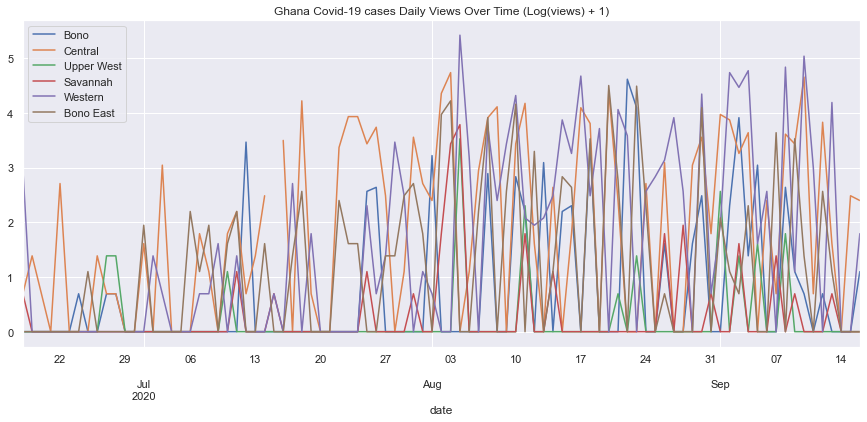

In [12]:
def plot_random_series(df_piv, n_series):
    
    
    sample = df_piv.sample(n_series)
    page_labels = sample.index.tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(15,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Ghana Covid-19 cases Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(target_df, 6)

### Days of the week

In [13]:
#one-hot-encode the days of the week for all the timesteps
dow_one_hot = pd.get_dummies(pd.to_datetime(target_df.columns).dayofweek)
dow_one_hot

,0,1,2,3,4,5,6
0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
86,0,0,0,0,0,1,0
87,0,0,0,0,0,0,1
88,1,0,0,0,0,0,0
89,0,1,0,0,0,0,0


In [14]:
# Expand the dimension of the data along the `batches` axis
dow_array = np.expand_dims(dow_one_hot,axis=0)

# Repeat the `dow_array` along the sample axis thus 16 times
dow_array = np.tile(dow_array,(target_df.shape[0],1,1)) 

In [71]:
def get_additional_data(df):
    """function to format external data
    return a tuple of (index_names,data)
    """

    # create an empty list
    pivoted_array_list = list()


    for feat in df.drop(['date','region','new_case'],axis=1).columns:
        temp_df = df.pivot(values=[feat],index='region',columns='date')
        temp_arr = temp_df.values
    #     fill nan values with zero and normalize the data with np.log1p() function
        temp_arr = np.log1p(np.nan_to_num(np.abs(temp_arr)))
    #     de-mean the data
        mean = temp_arr.mean(axis=1).reshape(-1,1)
        temp_arr = temp_arr-mean
        pivoted_array_list.append(temp_arr)
        
    ind = temp_df.index.tolist()
    return ind,np.transpose(pivoted_array_list,(1,2,0))

indx,additional_data = get_additional_data(df)

### Now let's combine the the `dow_array` with the `additional features`

In [16]:
exog_feat = np.concatenate([dow_array,additional_data],axis = -1)
print(exog_feat.shape)

(16, 91, 10)


We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 7 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 7 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [17]:
pred_steps = 7
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [18]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [19]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2020-06-18 00:00:00 - 2020-09-02 00:00:00
Train prediction: 2020-09-03 00:00:00 - 2020-09-09 00:00:00 

Val encoding: 2020-06-25 00:00:00 - 2020-09-09 00:00:00
Val prediction: 2020-09-10 00:00:00 - 2020-09-16 00:00:00

Encoding interval: 77
Prediction interval: 7


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 
* Create final function to extract complete encoding and target arrays, leveraging prior functions 
    - This will act as a one-shot function that grabs what we need to train or predict
    - It will extract (transformed) endogenous series data and combine it with our exogenous features

In [20]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in target_df.columns]),
                          data=[i for i in range(len(target_df.columns))])

series_array = target_df[target_df.columns].values


def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]

    return series_array[:,inds]

def transform_series_encode(series_array):

    series_array = np.log1p(np.abs(series_array)) # filling NaN with 0

    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean

    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(np.abs(series_array))) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    return series_array

In [54]:
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)[:first_n_samples]
    
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    
    
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
#     print(exog_input_data[0,0,:],'\n\n')
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
#     print(encoder_input_data[0,0,:])
    return encoder_input_data, decoder_target_data,encode_series_mean

# Model Creation

In [22]:
class timeseries_hypermodel(HyperModel):        
    def build(self,hp):
        # convolutional operation parameters
        hp.Choice('num_filters',values=[4,8,16,32,64,128,256],default=32)
        hp.Choice('kernel_size',values=[1,2,3,7],default=3)
        dilation_rates = [2**i for i in range(8)] * 2 

        # define an input history series and pass it through a stack of dilated causal convolution blocks. 
        # Note the feature input dimension corresponds to the raw series and all exogenous features  

        history_seq = Input(shape=(None, 1 + exog_feat.shape[-1]))
        x = history_seq

        n_filters = hp.get('num_filters')
        filter_width = hp.get('kernel_size')
        
        skips = []
        for dilation_rate in dilation_rates:

            # preprocessing - equivalent to time-distributed dense
            
            x = Conv1D(filters=n_filters,kernel_size=filter_width, padding='same', activation='relu')(x) 

            # filter convolution
#             for i in range(hp.Int('filters',min_value=4,max_value=128,step=32)):
            x_f = Conv1D(filters=n_filters,
                         kernel_size=filter_width,
                         padding='causal',dilation_rate=dilation_rate)(x)

            # gating convolution
#         filters=hp.Int('filters',4,8,16,32,64),hp.Int('kernel_size',1,2,3,7)
            x_g = Conv1D(filters=n_filters,
                         kernel_size=filter_width, 
                         padding='causal',
                         dilation_rate=dilation_rate)(x)

            # multiply filter and gating branches
            z = Multiply()([Activation('tanh')(x_f),
                            Activation('sigmoid')(x_g)])

            # postprocessing - equivalent to time-distributed dense
#             hp.Int('filters',4,8,16,32,64,128)hp.Int('kernel_size',1,2,3,7)
#  hp.Choice('activation',values=['relu','tanh','sigmoid'],default='relu'
            z = Conv1D(filters=n_filters,
                         kernel_size=filter_width,
                       padding='same',
                       activation =hp.Choice('activation',values=['relu','tanh','sigmoid'],default='relu')
                      )(z)

            # residual connection
            x = Add()([x, z])    

            # collect skip connections
            skips.append(z)

        # add all skip connection outputs 
        out = Activation(activation=hp.Choice('activation',values=['relu','tanh','sigmoid'],default='relu'))(Add()(skips))

        # final time-distributed dense layers 
        out = Conv1D(filters=hp.Choice('num_filters',values=[4,8,16,32,64,128,256],default=32),
                     kernel_size=hp.Choice('kernel_size',values=[1,2,3,7]),padding='same')(out)
        
        out = Activation(activation=hp.Choice('activation',values=['relu','tanh','sigmoid'],default='relu'))(out)
        
        out = Dropout(rate=hp.Float('dropout',min_value=0.2,max_value=0.6,default=0.2,step=0.1))(out)
        out = Conv1D(1, 1, padding='same')(out)

        # extract the last 7 time steps as the training target
        def slice(x, seq_length):
            return x[:,-seq_length:,:]

        pred_seq_train = Lambda(slice, arguments={'seq_length':7})(out)

        model = Model(history_seq, pred_seq_train)
        
        model.compile(optimizer=Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )), 
                      loss='mean_absolute_error',metrics=['mean_absolute_error'])
        
        model.summary()
        
        return model

In [103]:
# initialize the hypermodel
hypermodel = timeseries_hypermodel()

# Give a seed value
SEED = 1234

tuner_rs = RandomSearch(hypermodel,objective='mean_absolute_error',
                        seed=SEED,max_trials=20,executions_per_trial=2,directory='./second_run7')

In [101]:
# check the search space
tuner_rs.search_space_summary()

In [70]:
# Get the number of batches to use
first_n_samples = target_df.shape[0]
batch_size = 2**5

# Get the encoding data
encoder_input_data, decoder_target_data,enc_mean = get_data_encode_decode(series_array, exog_feat,
                                                            first_n_samples, date_to_index, train_enc_start, train_enc_end,
                                                             train_pred_start, train_pred_end)

# Get the decoding data
val_encoder_input_data, val_decoder_target_data,_ = get_data_encode_decode(series_array, exog_feat, df.shape[0],
                                                        date_to_index, val_enc_start, val_enc_end, val_pred_start, 
                                                        val_pred_end)


In [99]:
print('Training Set \n X_train shape = {} \n y_train shape = {} \n\n'.format(encoder_input_data.shape,decoder_target_data.shape))
print('Validating Set \n X_val shape = {} \n y_val shape = {}'.format(val_encoder_input_data.shape, val_decoder_target_data.shape))

Training Set 
 X_train shape = (16, 83, 11) 
 y_train shape = (16, 7, 1) 


Validating Set 
 X_val shape = (16, 83, 11) 
 y_val shape = (16, 7, 1)


In [100]:
# Start searching for good parameters with 250 epoches
tuner_rs.search(encoder_input_data, decoder_target_data, epochs=250, validation_split=0.2,
                validation_data=(val_encoder_input_data, val_decoder_target_data),verbose=1)


* After the entire random searching, get the best model.   
* From the keras documentation, it is not recommended to use this as a final model.

In [ ]:
# Get the best model from the random search
best_model = tuner_rs.get_best_models()[0]

In [ ]:
# Save the best model to file
best_model.save('./models/bestmodelv3.h5')

* The recommended approach is to get the best parameters and fit it to the entire dataset and done below

In [ ]:
# Get best parameters
best_param = tuner_rs.get_best_hyperparameters()[0]
# build the best parameters and assign it to a variable
model = tuner_rs.hypermodel.build(best_param)

In [ ]:
# Fit with the best parameters to the entire dataset
history = model.fit(encoder_input_data, decoder_target_data, epochs=500, validation_split=0.2,
                validation_data=(val_encoder_input_data, val_decoder_target_data),verbose=1)

In [ ]:
# We will visualize the train and test loss

len(history.history['loss'])

history.history['val_loss']
plt.figure(figsize=(10,6))

plt.plot(range(len(history.history['loss'])),history.history['loss'],color='red')
plt.plot(range(len(history.history['val_loss'])),history.history['loss'],color='blue',linestyle='--')
plt.legend(['Training loss','Validation loss'])

In [ ]:
# save the new model
model.save('./models/bestmodelv4.h5')

#### After saving the model we would like to load it

In [104]:
# Using the keras load_model() function
model = load_model('./models/bestmodelv4.h5')

In [113]:
model.loss

<function tensorflow.python.keras.losses.mean_absolute_error(y_true, y_pred)>

## 5. Building the Model - Inference Loop

we'll generate predictions by running our `model` in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. In each iteration we'll also update the exogenous features to include values corresponding to the next time step we'll predict. With $7$ iterations, this lets us generate predictions for the full interval we've chosen. 

Recall that we designed our model to output predictions for $7$ time steps at once in order to use teacher forcing for training. So if we start from a history sequence and want to predict the first future time step, we can run the model on the history sequence and take the last time step of the output, which corresponds to one time step beyond the history sequence. 

In [32]:
def predict_sequence(model,input_tensor,enc_mean,reverse_log=False,mc_dropout=False):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        if mc_dropout:
            last_step_pred = (np.stack([model(history_tensor,training=True) for _ in range(100)]).mean(axis=0))[0,-1,0]
        else:
            last_step_pred = model.predict(history_tensor)[0,-1,0]
            
#         last_step_pred = prediction
        
#         reverse transform the log1p
        if reverse_log:
            pred_sequence[0,i,0] = np.exp(last_step_pred+enc_mean)-1
        else:
            pred_sequence[0,i,0] = last_step_pred

        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)),last_step_exog], axis=-1)
        
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)
        
    return pred_sequence

In [85]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_mean,reg_name,enc_tail_len=7,
                     reverse_log=True,mc_dropout=True):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = predict_sequence(encode_tensor,enc_mean[sample_ind],reverse_log,mc_dropout)
    
    encode_series = encode_tensor[:,:(-pred_steps+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions ' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

# Let us do some small predictions on the validation dataset

In [82]:
# Get the decoding data
val_encoder_input_data, val_decoder_target_data,enc_mean= get_data_encode_decode(series_array, exog_feat, df.shape[0],
                                                        date_to_index, val_enc_start, val_enc_end, val_pred_start, 
                                                        val_pred_end)

In [67]:
print('Prediction',predict_sequence(val_encoder_input_data[[9],:,:],mean[9],reverse_log=True,mc_dropout=True))

print('Ground truth',(np.exp(val_decoder_target_data[9]+mean[9])-1))

Prediction [[[2.27174026]
  [0.62149689]
  [1.96453437]
  [1.7418837 ]
  [0.924903  ]
  [1.74413896]
  [1.31885787]]]
Ground truth [[0.]
 [2.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]


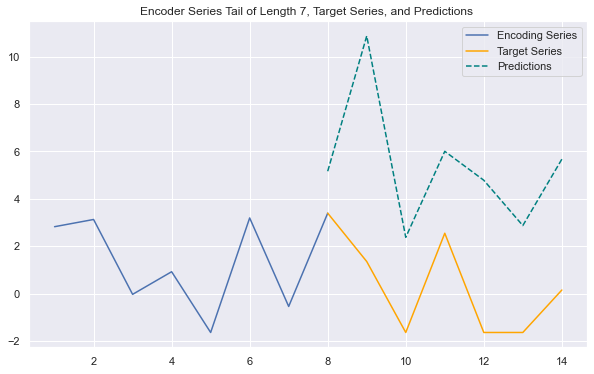

In [89]:
predict_and_plot(val_encoder_input_data, val_decoder_target_data,14, enc_mean,reg_name)

 **From the above plot, its clear that the network knows the trends and if the below future version techniques are applied, we are hopeful to get an amazing results.**

# Future versions

The following technics must be considered for future model improvement

>Adding more dataset. It can be observed from the training set that, the neural network learns from only 77 timesteps which is extremely small for the network to make an accurate generalization but even with this little dataset, the train and val loss is decent. So, we need to add more dataset in the next version.  

> We will also consider the following multiple ensemble techniques:  
   * `Model averaging` is an ensemble learning technique that reduces the variance in a final neural network model, sacrificing spread in the performance of the model for a confidence in what performance to expect from the model.
   [Visit for details](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/)
   * Another approach to address this problem is to use an `average of the weights` from multiple models seen toward the end of the training run.[Visit for details](https://machinelearningmastery.com/polyak-neural-network-model-weight-ensemble/)
   * `Stacked Generalization Ensemble` [Visit here for details](https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/)
   * `Weighted Average Ensemble` [Visit here for details](https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/)

### Please if you find this notebook as helpful, kindly give out your comments and suggestions to improve this notebook.

### Thank you